# 基于关键词词频技术的气候风险指数

## 1. Idea

气候风险评估通常需要从多个维度（如关键词频率、情感倾向等）收集信息，而这些维度的信息往往具有不同的量纲和重要性。

关键词的出现频率反映了文本中与特定风险指标（如“洪水”、“碳排放”）相关的关注程度。频率越高，可能表明该风险在文本中被强调的程度越高，因此是风险评估的重要信号。

情感得分反映了文本对气候风险的态度（正面、负面或中性）。例如，负面情感可能表明对风险的担忧或问题严重性，而正面情感可能表明对风险的应对措施持乐观态度。情感分析补充了关键词频率的不足，使得评估不仅关注“说了什么”，还关注“怎么说”。

通过量化指数，可以将异质数据（如关键词计数和情感得分）标准化并整合为单一的指标，便于比较和决策。过设置权重（如 weight_keywords=0.7, weight_sentiment=0.3），强调不同维度对整体风险评估的相对重要性。
$$
index = keyword\_score * 0.7 + sentiment * 0.3
$$
通过加权平均可以在关键词频率和情感分析之间进行权衡，确保最终指标既反映了关键词频率，又反映了情感倾向。

In [1]:
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

## 2. Dateset

Here is a quick overview of the 10-Q filing from Exxon Mobil Corporation (XOM), a multinational oil and gas company listed on the New York Stock Exchange (NYSE). We can develop code to automatically download such filings from the [*SEC's EDGAR database*](https://www.sec.gov/edgar/), where reports are typically presented in HTML format.

最为对比，下载美国最大的可再生能源公司之一NextEra Energy, Inc. (NEE)，NextEra Energy 在其10-Q报告中可能会提及“renewable energy”、“solar power”、“wind power”、“energy transition”以及“emission reduction target”等关键词。该公司积极投资于低碳技术，并且可能披露与气候政策（如“carbon pricing”或“climate regulation”）相关的风险。

<img src='images/EDGAR.png' width=400><img src='images/XOM-10-Q.png'  width=410>

## 3. Implementation

### Extract text from HTML file

We can implement a function like `extract_text_from_html(html_path)` to read an HTML file using UTF-8 encoding, parse it with BeautifulSoup, extract readable text by removing tags and whitespace, handle errors, and return the text as a string—streamlining report content analysis.

In [2]:
def extract_text_from_html(html_path):
    text = ""
    try:
        # Read the HTML file
        with open(html_path, 'r', encoding='utf-8') as file:
            soup = BeautifulSoup(file, 'html.parser')
            text = soup.get_text(separator=' ', strip=True)
    except Exception as e:
        print(f"Error reading HTML: {e}")
    return text

### Keyword frequency counting

In [3]:
climate_keywords = {
    "Extreme Weather Risk Index": ["flood", "hurricane", "drought", "extreme heat", "storm"],
    "Greenhouse Gas Emission Intensity Index": ["carbon emission", "greenhouse gas", "emission intensity", "carbon dioxide", "emission reduction target"],
    "Climate Adaptability and Resilience Index": ["climate resilience", "infrastructure upgrade", "emergency plan", "climate adaptation", "adaptation plan"],
    "Renewable Energy Investment and Transition Progress Index": ["renewable energy", "solar power", "wind power", "low-carbon technology", "energy transition"],
    "Policy and Legal Risk Index": ["carbon tax", "emission trading", "climate regulation", "policy uncertainty", "carbon pricing"]
}

考虑到这些词在每个季度的报告中，出现频率较低，所以将这些关键词结合在一起，它们共同反映了气候相关的风险、适应能力、政策影响和能源转型进程，可以概括为：综合气候风险与适应能力指数（Comprehensive Climate Risk and Adaptability Index, CCRA Index）这个指数可以用来衡量企业在气候变化相关领域的综合表现，既考虑风险因素，也涵盖应对和政策层面，适用于金融投资、政策评估和可持续发展研究

In [4]:
climate_keywords['Comprehensive Climate Risk and Adaptability Index'] = [
    "flood", "hurricane", "drought", "extreme heat", "storm",
    "carbon emission", "greenhouse gas", "emission intensity", "carbon dioxide", "emission reduction target",
    "climate resilience", "infrastructure upgrade", "emergency plan", "climate adaptation", "adaptation plan",
    "renewable energy", "solar power", "wind power", "low-carbon technology", "energy transition",
    "carbon tax", "emission trading", "climate regulation", "policy uncertainty", "carbon pricing"
]

This function, `extract_keywords(text, keywords_dict)`, takes a text string and a dictionary of keywords, converts the text to lowercase, and counts the occurrences of each keyword (case-insensitive) within the text using regular expressions, returning a dictionary of keyword counts organized by indicator.

In [5]:
def extract_keywords(text, keywords_dict):
    text = text.lower()  
    keyword_counts = {}
    
    for indicator, keywords in keywords_dict.items():
        counts = Counter()
        for keyword in keywords:
            keyword = keyword.lower()
            counts[keyword] = len(re.findall(r'\b' + re.escape(keyword) + r'\b', text))
        keyword_counts[indicator] = counts
    return keyword_counts

### Quantify indicators

In [7]:
def quantify_indicators(keyword_counts, text, weight_keywords=0.7, weight_sentiment=0.3):
    indicators = {}
    for indicator, counts in keyword_counts.items():
        total_mentions = sum(counts.values())
        #keyword_score = total_mentions / 100  # Assume normalization factor of 100, adjust as needed
        #indicator_score = keyword_score * weight_keywords + sentiment * weight_sentiment
        indicators[indicator] = total_mentions #indicator_score
    return indicators

### Visualize indicators

In [8]:
def plot_indicators(indicators, title, figsize=(8,6)):
    df = pd.DataFrame.from_dict(indicators, orient='index', columns=['Score'])
    #df = df.sort_values(by='Score', ascending=False)
    plt.figure(figsize=figsize)
    sns.barplot(x=df.index, y='Score', data=df, palette='viridis', hue=df.index, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Date')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Exact date from 10-Q

In [9]:
def extract_10_Q_date(text):
    date = text.split('For the quarterly period ended ')[-1].split(' Commission File')[0].split(' OR ')[0]
    return date

### Main function: Process a single report

In [10]:
def process_report(html_path):
    with tqdm(total=4, desc="Processing steps", unit="step") as pbar:
        pbar.set_description("Step 1 Extracting text from HTML")
        text = extract_text_from_html(html_path)
        if not text:
            print("No text extracted from the HTML.")
            return
        pbar.update(1)
        
        pbar.set_description("Step 2 Extracting keyword counts")
        climate_keyword_counts = extract_keywords(text, climate_keywords)
        pbar.update(1)
        
        pbar.set_description("Step 3 Quantifying climate indicators")
        climate_indicators = quantify_indicators(climate_keyword_counts, text)
        pbar.update(1)
        
        pbar.set_description("Step 4 Extracting date")
        date = extract_10_Q_date(text)
        pbar.update(1)
        
    return date, climate_indicators

        # Print keyword frequencies
    # print("\n=== Climate Risk Keyword Counts ===")
    # for indicator, counts in climate_keyword_counts.items():
    #     print(f"{indicator}: {dict(counts)}")
    
    # print("\n=== Climate Risk Indicators ===")
    # for indicator, score in climate_indicators.items():
    #     print(f"{indicator}: {score:.4f}")
    # print("\n===============================")

## 4. Test

In [11]:
html_path = "datasets/sec-edgar-filings/NEE/10-Q-htm/full-submission-0000753308-24-000057.htm"  
date, climate_indicators = process_report(html_path)

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

In [12]:
climate_indicators

{'Extreme Weather Risk Index': 158,
 'Greenhouse Gas Emission Intensity Index': 1,
 'Climate Adaptability and Resilience Index': 0,
 'Renewable Energy Investment and Transition Progress Index': 37,
 'Policy and Legal Risk Index': 0,
 'Comprehensive Climate Risk and Adaptability Index': 196}

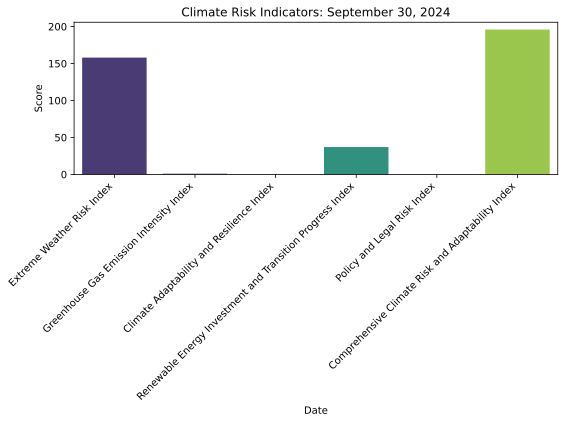

In [13]:
plot_indicators(climate_indicators, f"Climate Risk Indicators: {date}")

## 5. All Index

In [14]:
import os
from tqdm.notebook import tqdm

path = 'datasets/sec-edgar-filings/NEE/10-Q-htm/'
l = os.listdir(path)
l.sort()
EWR, GGEI, CAR, PEITP, PLR, CCRA = {}, {}, {}, {}, {}, {}

# 使用 tqdm 创建进度条实例
for i in tqdm(l, desc="Processing files", unit="file"):
    if 'full' not in i: continue
    html_path = os.path.join(path, i)
    # tqdm.set_description(f"Processing {i}")
    date, climate_indicators = process_report(html_path)

    EWR[date] = climate_indicators["Extreme Weather Risk Index"]
    GGEI[date] = climate_indicators["Greenhouse Gas Emission Intensity Index"]
    CAR[date] = climate_indicators["Climate Adaptability and Resilience Index"]
    PEITP[date] = climate_indicators["Renewable Energy Investment and Transition Progress Index"]
    PLR[date] = climate_indicators["Policy and Legal Risk Index"]
    CCRA[date] = climate_indicators['Comprehensive Climate Risk and Adaptability Index']

Processing files:   0%|          | 0/30 [00:00<?, ?file/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

Processing steps:   0%|          | 0/4 [00:00<?, ?step/s]

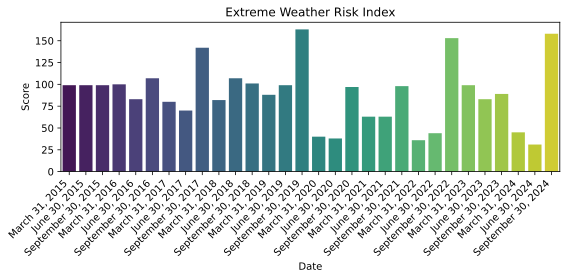

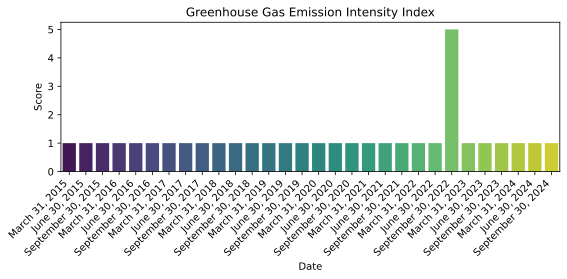

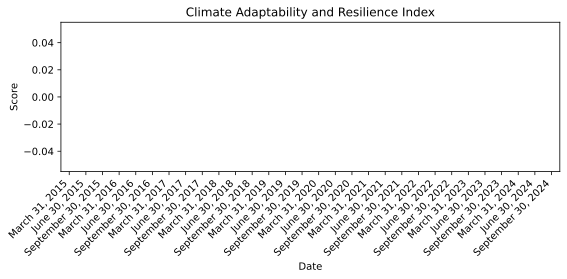

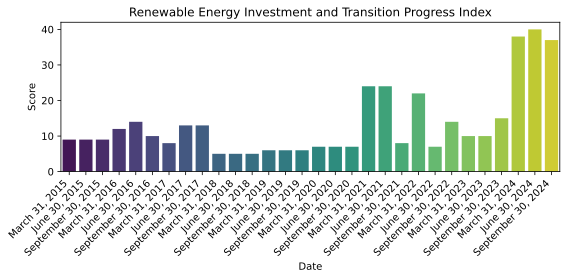

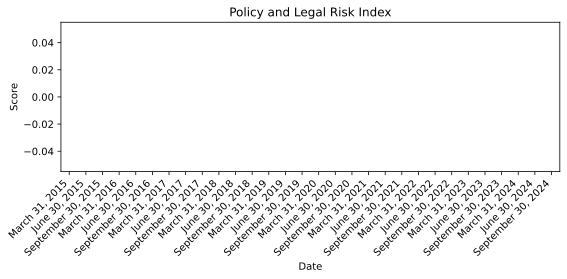

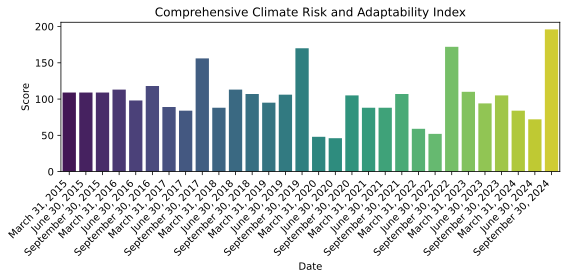

In [18]:
plot_indicators(EWR, "Extreme Weather Risk Index", (8,4))
plot_indicators(GGEI, "Greenhouse Gas Emission Intensity Index", (8,4))
plot_indicators(CAR, "Climate Adaptability and Resilience Index", (8,4))
plot_indicators(PEITP, "Renewable Energy Investment and Transition Progress Index", (8,4))
plot_indicators(PLR, "Policy and Legal Risk Index", (8,4))
plot_indicators(CCRA, "Comprehensive Climate Risk and Adaptability Index", (8,4))